<a href="https://colab.research.google.com/github/lorenzogiarnese/forecasting-volatility-as-a-service/blob/main/volatility_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 !pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 916.4/916.4 kB 14.3 MB/s eta 0:00:00


In [2]:
 !pip3 install yfinance

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from scipy import stats
from scipy.interpolate import interp1d


%matplotlib inline

In [4]:
import yfinance as yf

from datetime import datetime

#**Parameters selection**

In [5]:
# predetermine desired test & validation sizes
test_size = 30
val_size = 365

In [6]:
INTERVAL_WINDOW = 30

#set number of periods about which receiving forecast
n_future = 7

In [7]:
# set input parameters for GARCH model
p_value = 1
q_value = 1

By setting the `INTERVAL_WINDOW `to 30, it means calculating the volatility over a 30-day time window. This value is derived from practical experiments, it is shown that the `INTERVAL_WINDOW` equal to 30 provides a good granularity.

The positive aspect of calculating volatility over a restricted time window like the `INTERVAL_WINDOW` is that it can provide a more sensitive and up-to-date measure of return variability in the short term. Some of the advantages include:

* Sensitivity to recent changes: By using a restricted time window, volatility will be primarily influenced by the most recent returns. This can be useful in quickly capturing volatility changes in the short term, such as during periods of high uncertainty or significant news that can impact asset prices.
* Adaptability to changing market conditions: Financial markets can experience significant and sudden changes in conditions. By using a restricted time window, the volatility calculation will be more responsive to these changes, allowing for faster identification of periods of higher volatility or changes in price dynamics.
* Response to seasonal or cyclical events: If there are seasonal or cyclical patterns in asset returns, using a restricted time window can help capture these fluctuations in the short term. For example, there may be increased volatility during holiday periods or during the sales season.
However, it's important to consider that a broader time window can provide a more comprehensive and stable view of long-term volatility. Therefore, the use of a restricted time window like the `INTERVAL_WINDOW` is a choice that depends on the specific context of the analysis and the objectives of the investor or researcher.





Here are some approximations for common time intervals:

-> **7 days (1 week)**: Set forecast_horizon to 5 (assuming a 5-day trading week).

-> **30 days (1 month)**: Set forecast_horizon to approximately 20 (considering an average of 20 trading days in a month).

-> **90 days (3 months)**: Set forecast_horizon to around 60 (based on approximately 60 trading days in 3 months).

-> **150 days (5 months)**: Set forecast_horizon to roughly 100 (considering an average of 20 trading days per month).

In [8]:
def switch(n_future):
  match n_future:
    case 7:
      return 5
    case 30:
      return 20
    case 90:
      return 60
    case 150:
      return 100


In [9]:
horizon = switch(n_future)

#**Data Preparation and Data Exploration**

* Start with a time series dataset of one financial asset.
* Implement time-based interpolation using spline interpolation in order to deal with missing values in the dataset.
* Calulate returns as daily percentage change using the function 'pct_change()'.
* Calculate log returns.



In [10]:
start = datetime(2016, 1, 1)
end = datetime(2023,6,15)

tckr = 'AAPL'

ticker = yf.Ticker(tckr)

df = ticker.history(start=start, end=end, interval="1d")

In [11]:
# Create a mask for missing values
mask = df.isnull()

# Iterate over the columns to apply time-based interpolation
for column in df.columns:
    # Skip columns that don't have missing values
    if not mask[column].any():
        continue

    # Create a Series of time values corresponding to the missing values
    time_values = pd.to_numeric(df[mask[column]].index)

    # Create a Series of observed values without missing values
    observed_values = df.loc[~mask[column], column]

    # Perform spline interpolation
    interpolated_values = interp1d(pd.to_numeric(df.loc[~mask[column]].index), observed_values, kind='cubic')(time_values)

    # Update the DataFrame with interpolated values
    df.loc[mask[column], column] = interpolated_values

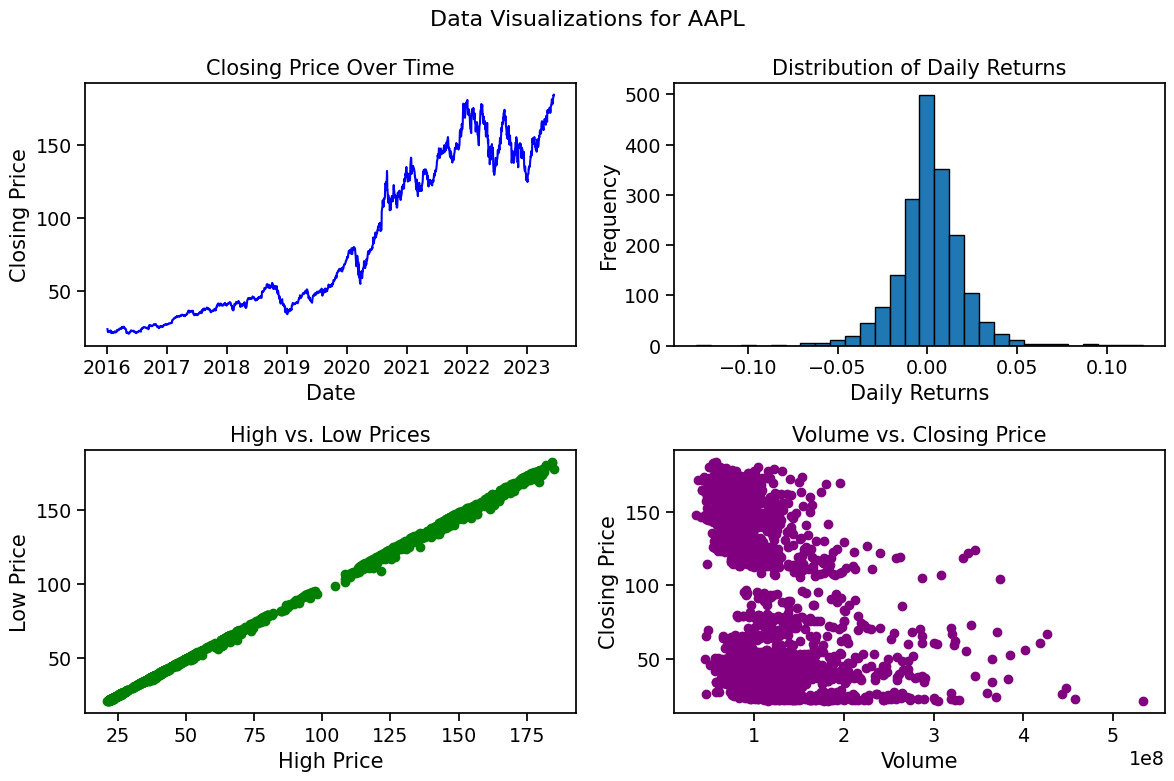

In [13]:
# Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Data Visualizations for {}'.format(tckr), fontsize=16)

# Line Graph - Volatility Over Time
axs[0, 0].plot(df['Close'], color='blue')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Closing Price')
axs[0, 0].set_title('Closing Price Over Time')

# Histogram - Daily Returns
axs[0, 1].hist(df['Close'].pct_change(), bins=30, edgecolor='black')
axs[0, 1].set_xlabel('Daily Returns')
axs[0, 1].set_ylabel('Frequency')
axs[0, 1].set_title('Distribution of Daily Returns')

# Scatter Plot - High vs. Low Prices
axs[1, 0].scatter(df['High'], df['Low'], color='green')
axs[1, 0].set_xlabel('High Price')
axs[1, 0].set_ylabel('Low Price')
axs[1, 0].set_title('High vs. Low Prices')

# Scatter Plot - Volume vs. Close Price
axs[1, 1].scatter(df['Volume'], df['Close'], color='purple')
axs[1, 1].set_xlabel('Volume')
axs[1, 1].set_ylabel('Closing Price')
axs[1, 1].set_title('Volume vs. Closing Price')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

**Volatility:** Volatility measures the degree of variation or dispersion of returns. It quantifies the level of uncertainty or risk associated with an asset's price movements. Volatility is typically calculated as the standard deviation or variance of returns. Higher volatility indicates larger price fluctuations, which implies greater risk.

**Volatility and returns:** Volatility is a measure of the dispersion of returns. Higher volatility indicates a wider range of returns, indicating greater uncertainty or risk. Volatility is commonly used to assess the risk associated with an asset or portfolio.

**Volatility and log returns:** Volatility is typically calculated based on log returns rather than simple returns. This is because log returns have better statistical properties for modeling and analysis. The volatility calculated using log returns is often referred to as historical volatility or realized volatility.

In [14]:
#calculate price returns as daily percentage using pct_change()
df['returns'] = 100 * df.Close.pct_change().dropna()

#df.Close.shift(1) è la riga successiva della colonna che rappresenta il prezzo di chiusura del giorno successivo
df['log_returns'] = np.log(df.Close/df.Close.shift(1)).dropna()

In [15]:
#devo droppare la prima riga perchè il valore pt-1 non esiste
df.drop(df.index[0], inplace=True)
df = df.drop(['Dividends', 'Stock Splits'], axis=1)
df.dropna(inplace=True)
df.describe()

,Open,High,Low,Close,Volume,returns,log_returns
count,1874.000000,1874.000000,1874.000000,1874.000000,1.874000e+03,1874.000000,1874.000000
mean,82.293585,83.244984,81.407962,82.372191,1.174047e+08,0.126437,0.001086
std,51.908751,52.572744,51.285441,51.961680,5.749428e+07,1.886487,0.018871
min,20.775700,21.161204,20.653356,20.854187,3.519590e+07,-12.864699,-0.137708
25%,37.813905,38.089021,37.456076,37.792242,7.990890e+07,-0.743575,-0.007464
50%,54.653745,54.976221,54.077133,54.509354,1.034370e+08,0.097017,0.000970
75%,135.178811,137.474075,133.753586,135.298248,1.375603e+08,1.056479,0.010509
max,183.369995,184.949997,182.440002,183.949997,5.334788e+08,11.980828,0.113157


<ipython-input-16-533f47521d35>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.returns, norm_hist=True, fit=stats.norm, color='blue',
<ipython-input-16-533f47521d35>:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.log_returns, norm_hist=True, fit=stats.norm, color='green',


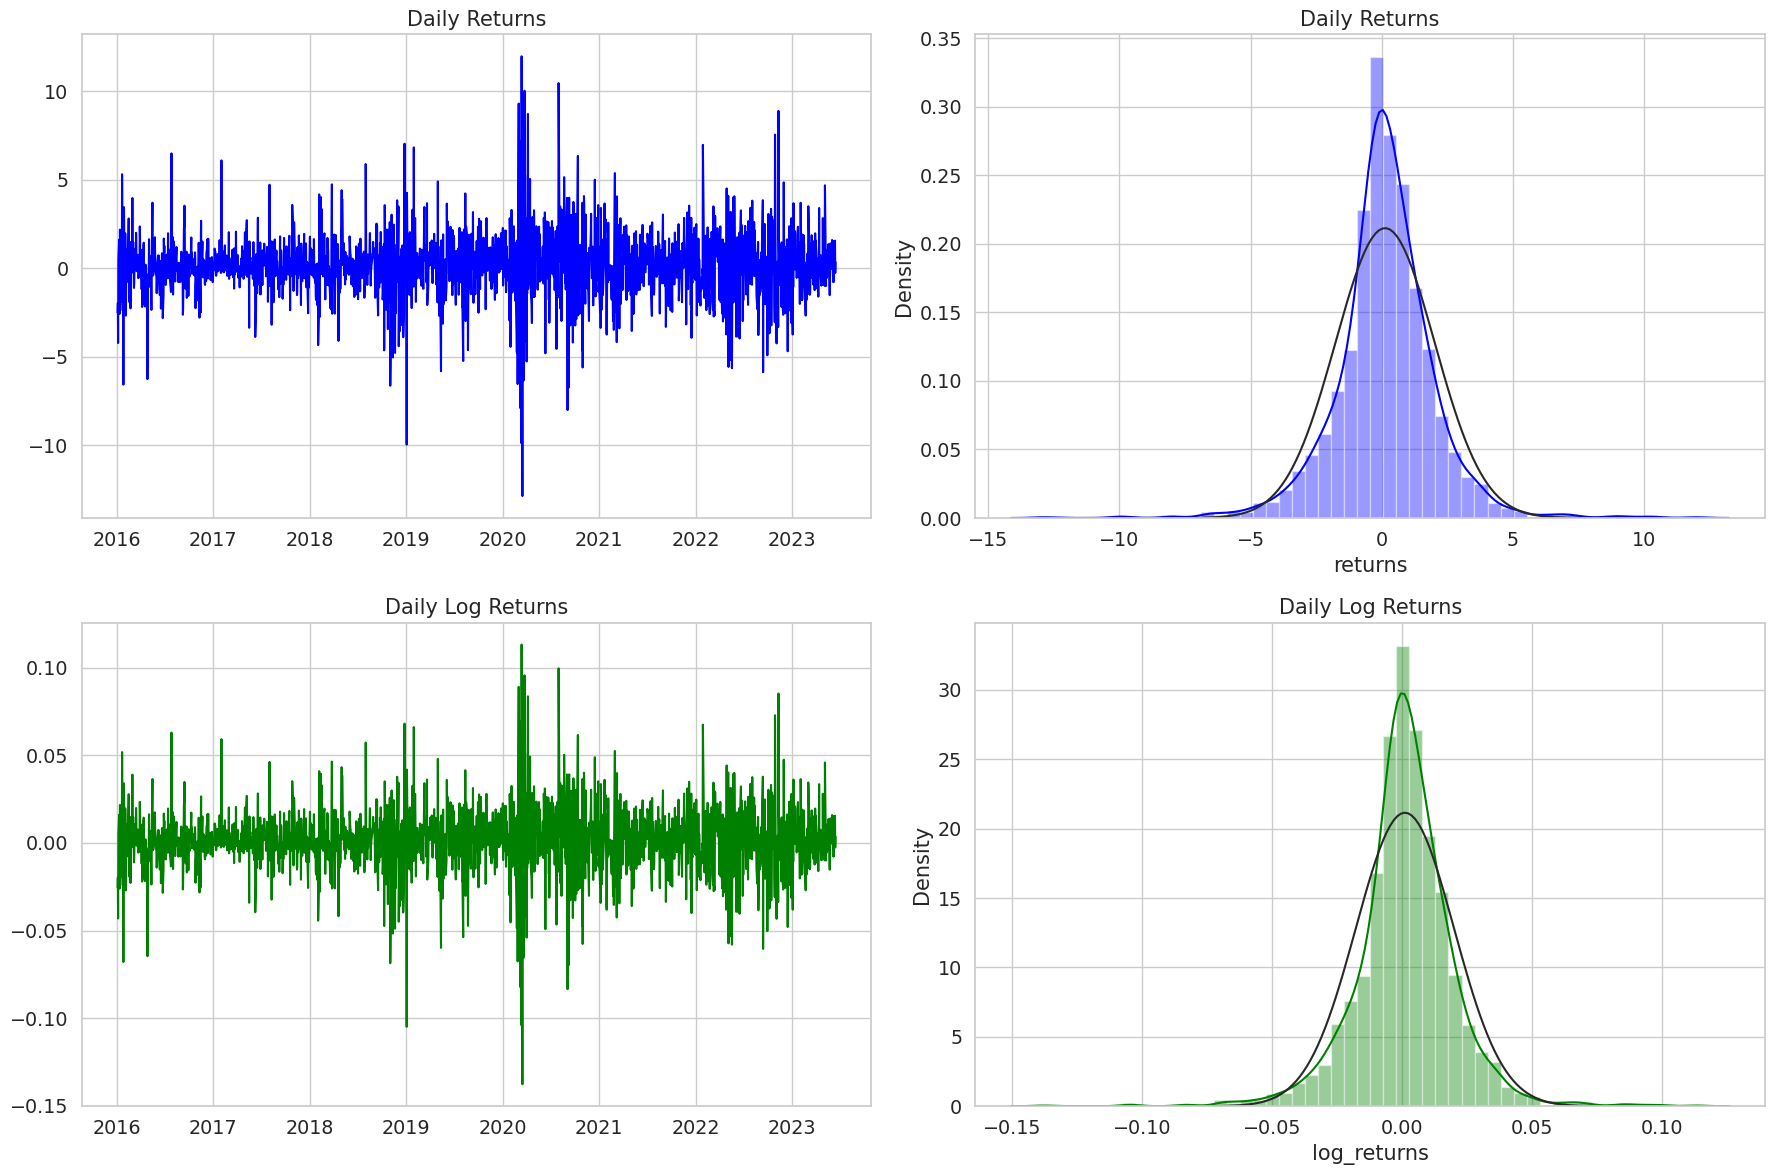

In [16]:
#plot distribution plots of log returns
with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18,12))

    axes[0][0].plot(df.returns, color='blue')
    axes[0][0].set_title('Daily Returns')

    sns.distplot(df.returns, norm_hist=True, fit=stats.norm, color='blue',
                bins=50, ax=axes[0][1])
    axes[0][1].set_title('Daily Returns')


    axes[1][0].plot(df.log_returns, color='green')
    axes[1][0].set_title('Daily Log Returns')

    sns.distplot(df.log_returns, norm_hist=True, fit=stats.norm, color='green',
                bins=50, ax=axes[1][1])
    axes[1][1].set_title('Daily Log Returns')
    plt.tight_layout()
    fig.show();

In [17]:
df.log_returns.describe()

count    1874.000000
mean        0.001086
std         0.018871
min        -0.137708
25%        -0.007464
50%         0.000970
75%         0.010509
max         0.113157
Name: log_returns, dtype: float64

In [18]:
#calculate the daily volatility
df['volatility'] = df.log_returns.abs()

In [19]:
df.describe()

,Open,High,Low,Close,Volume,returns,log_returns,volatility
count,1874.000000,1874.000000,1874.000000,1874.000000,1.874000e+03,1874.000000,1874.000000,1874.000000
mean,82.293585,83.244984,81.407962,82.372191,1.174047e+08,0.126437,0.001086,0.013082
std,51.908751,52.572744,51.285441,51.961680,5.749428e+07,1.886487,0.018871,0.013640
min,20.775700,21.161204,20.653356,20.854187,3.519590e+07,-12.864699,-0.137708,0.000000
25%,37.813905,38.089021,37.456076,37.792242,7.990890e+07,-0.743575,-0.007464,0.003854
50%,54.653745,54.976221,54.077133,54.509354,1.034370e+08,0.097017,0.000970,0.009124
75%,135.178811,137.474075,133.753586,135.298248,1.375603e+08,1.056479,0.010509,0.017967
max,183.369995,184.949997,182.440002,183.949997,5.334788e+08,11.980828,0.113157,0.137708


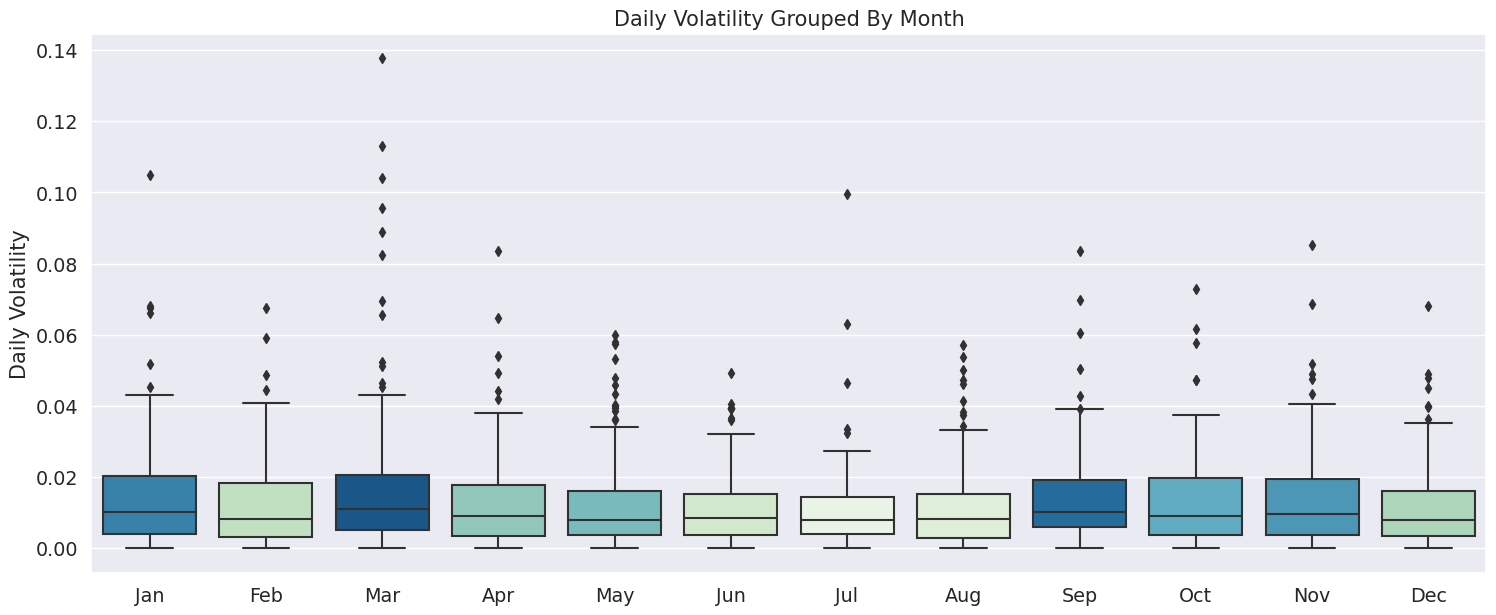

In [20]:
# Daily volatility grouped by month

# PRESORT MONTHS IN CHRONOLOGICAL ORDER
ordered_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# GROUP vol_current BY MONTH AND TAKE THE MEAN
data = df.groupby(by=[df.index.month_name()])['volatility'].mean()

# ABBREVIATE MONTH NAME
data.index = [x[:3] for x in data.index]

# SELECT PALETTE
pal = sns.color_palette("GnBu", len(data))

# SORT MONTH BY AVERAGE vol_current
rank = data.argsort().argsort().reindex(ordered_months)

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(18, 7))

    sns.boxplot(x=[x[:3] for x in df.index.month_name()],
                y=df['volatility'],
                palette=np.array(pal)[rank],
                order=ordered_months)
    ax.set(xlabel='',
           ylabel='Daily Volatility',
           title='Daily Volatility Grouped By Month')
    plt.show()

In [21]:
# CONVERT TO INDICES
split_time_1 = len(df) - (val_size + test_size)
split_time_2 = len(df) - test_size

# GET CORRESPONDING DATETIME INDICES FOR EACH SET
n_train = df.index[:split_time_1]
n_validation = df.index[split_time_1:split_time_2]
n_test = df.index[split_time_2:]

In [22]:
print(f'TRAINING \tFrom: {n_train[0]} \tto: {n_train[-1]} \t{len(n_train)} days')
print(f'VALIDATION \tFrom: {n_validation[0]} \tto: {n_validation[-1]} \t{len(n_validation)} days')
print(f'TEST \t\tFrom: {n_test[0]} \tto: {n_test[-1]} \t{len(n_test)} days')

TRAINING 	From: 2016-01-05 00:00:00-05:00 	to: 2021-11-16 00:00:00-05:00 	1479 days
VALIDATION 	From: 2021-11-17 00:00:00-05:00 	to: 2023-05-02 00:00:00-04:00 	365 days
TEST 		From: 2023-05-03 00:00:00-04:00 	to: 2023-06-14 00:00:00-04:00 	30 days


In [23]:
# SPLIT LOG RETURNS INTO 3 PARTS
lr_train = df.log_returns[n_train]
lr_val = df.log_returns[n_validation]
lr_test = df.log_returns[n_test]

The `realized_volatility_daily` function calculates the daily realized volatility from the daily log returns of a time series. Realized volatility is a measure of the variability of actual observed returns within the specified period.

In [24]:
def realized_volatility_daily(log_returns):
    """
    Calculate daily realized volatility, which is the square root of the sum of squared log returns.

    Parameters:
    log_returns (array-like): Array-like object containing the log returns.

    Returns:
    float: Daily realized volatility.
    """
    squared_returns = np.power(log_returns, 2)
    sum_squared_returns = np.sum(squared_returns)
    return np.sqrt(sum_squared_returns)

In [25]:
# GET BACKWARD LOOKING REALIZED VOLATILITY
df['volatility_current'] = df.log_returns.rolling(window=INTERVAL_WINDOW)\
                                   .apply(realized_volatility_daily)

# GET FORWARD LOOKING REALIZED VOLATILITY
df['volatility_future'] = df.log_returns.shift(-n_future)\
                                 .rolling(window=INTERVAL_WINDOW)\
                                 .apply(realized_volatility_daily)

In [26]:
# SPLIT CURRENT DAILY REALIZED VOLATILITY INTO 3 PARTS
x_train = df.volatility_current[n_train]
x_val = df.volatility_current[n_validation]
x_test = df.volatility_current[n_test]

In [27]:
# SPLIT FORWARD VOLATILITY INTO 3 PARTS
# (this would be the target)
y_train = df.volatility_future[n_train]
y_val = df.volatility_future[n_validation]
y_test = df.volatility_future[n_test]

In [28]:
# SPLIT RETURNS INTO 3 PARTS
# (this would be the input for GARCH models)
r_train = df.returns[n_train]
r_val = df.returns[n_validation]
r_test = df.returns[n_test]

In [29]:
df.describe()

,Open,High,Low,Close,Volume,returns,log_returns,volatility,volatility_current,volatility_future
count,1874.000000,1874.000000,1874.000000,1874.000000,1.874000e+03,1874.000000,1874.000000,1874.000000,1845.000000,1838.000000
mean,82.293585,83.244984,81.407962,82.372191,1.174047e+08,0.126437,0.001086,0.013082,0.094410,0.094293
std,51.908751,52.572744,51.285441,51.961680,5.749428e+07,1.886487,0.018871,0.013640,0.042385,0.042423
min,20.775700,21.161204,20.653356,20.854187,3.519590e+07,-12.864699,-0.137708,0.000000,0.028906,0.028906
25%,37.813905,38.089021,37.456076,37.792242,7.990890e+07,-0.743575,-0.007464,0.003854,0.067202,0.067131
50%,54.653745,54.976221,54.077133,54.509354,1.034370e+08,0.097017,0.000970,0.009124,0.084805,0.084772
75%,135.178811,137.474075,133.753586,135.298248,1.375603e+08,1.056479,0.010509,0.017967,0.106624,0.106401
max,183.369995,184.949997,182.440002,183.949997,5.334788e+08,11.980828,0.113157,0.137708,0.325303,0.325303


* In the GARCH modeling framework, it is generally recommended to work with standardized data rather than the raw data. This includes scaling the data before feeding it as input to the GARCH model. By scaling the data, you can ensure that the model treats each variable on a similar scale and avoids any potential issues arising from differences in magnitude.

In [30]:
def transform_to_scaler(scaler, tf_series):
    '''
    Transform a series to a fitted scaler
    '''
    idx = tf_series.index
    output = pd.Series(scaler.transform(tf_series.values.reshape(-1,1))[:,0],
                       index=idx)
    return output

In [31]:
# INITIATE SCALER
scaler = MinMaxScaler()

#ADDESTRAMENTO DELLO SCALER SU TRAIN_DATA
scaler = scaler.fit(x_train.values.reshape(-1,1))

In [32]:
# TRANSFORM TRAINING CURRENT & FUTURE VOLATILITIES
x_train_scaled = transform_to_scaler(scaler, x_train)
y_train_scaled = transform_to_scaler(scaler, y_train)

# TRANSFORMING VALIDATION CURRENT & FUTURE VOLATILITIES
x_val_scaled = transform_to_scaler(scaler, x_val)
y_val_scaled = transform_to_scaler(scaler, y_val)

# TRANSFORMING TEST CURRENT & FUTURE VOLATILITIES
x_test_scaled = transform_to_scaler(scaler, x_test)
y_test_scaled = transform_to_scaler(scaler, y_test)

In [33]:
x_train_scaled = pd.Series(x_train_scaled)
x_val_scaled = pd.Series(x_val_scaled)

combined_x_scaled = pd.concat([x_train_scaled, x_val_scaled])

In [34]:
#combine train dataset and validation dataset in a wider dataset

r_train = pd.Series(r_train)
r_val = pd.Series(r_val)
r_test = pd.Series(r_test)

combined_data = pd.concat([r_train, r_val])

In [35]:
#prepare the entire returns dataset useful to make the prediction
returns_dataset = pd.concat([r_train, r_val, r_test])

In [36]:
combined_data.describe()

count    1844.000000
mean        0.123559
std         1.895867
min       -12.864699
25%        -0.751739
50%         0.097017
75%         1.058974
max        11.980828
Name: returns, dtype: float64

#**Train the GARCH predictor**

* Fit the GARCH(1,1) model to the training set using the 'arch' library.
* The process of estimating the GARCH model involves using the log returns as input to calculate the conditional volatility, which represents the estimated or forecasted volatility.
* The GARCH(1,1) model estimates the conditional volatility, which represents the expected level of volatility given past information.
* The GARCH model incorporates an autoregressive component that takes into account the historical information from the log returns to capture the dynamics of volatility.

In [37]:
import arch
from arch import arch_model
import matplotlib.pyplot as plt

In [38]:
model = arch.arch_model(combined_data, vol='GARCH', p=p_value, q=q_value)
model_fit = model.fit(disp='off')

print()
print(model_fit.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3585.94
Distribution:                  Normal   AIC:                           7179.87
Method:            Maximum Likelihood   BIC:                           7201.95
                                        No. Observations:                 1844
Date:                Wed, Jul 19 2023   Df Residuals:                     1843
Time:                        12:52:20   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.2130  3.927e-02      5.425  5.804e-08 [  0.136,  0.2

In [39]:
def scale_tf_cond_vol(model_result):
    '''
    Scale & Transform Conditional Volatility
    Estimated by GARCH Models
    '''
    # OBTAIN ESTIMATED CONDITIONAL VOLATILITY FROM MODEL RESULT
    cond_vol = model_result.conditional_volatility

    # INITIATE SCALER
    scaler = MinMaxScaler()

    # FIT SCALER TO MODEL'S ESTIMATED CONDITIONAL VOLATILITY
    scaler = scaler.fit(cond_vol.values.reshape(-1,1))

    scaled_cond_vol = transform_to_scaler(scaler, cond_vol)
    return scaler, scaled_cond_vol

In [40]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_garch, scaled_cond_vol = scale_tf_cond_vol(model_fit)

scaled_cond_vol.describe()

count    1844.000000
mean        0.117864
std         0.102837
min         0.000000
25%         0.049641
50%         0.092110
75%         0.155966
max         1.000000
dtype: float64

In [41]:
# VISUALIZE MODEL'S ESTIMATED CONDITIONAL VOLATILITY
# WITH SCALED vol_current CALCULATED ABOVE
def viz_cond_vol(cond_vol_series, model_name):
    with sns.axes_style("whitegrid"):
        fig, ax = plt.subplots(figsize=(18,7))

        ax.plot(combined_x_scaled, color='blue', lw=2,
                #variabile INTERVAL_WINDOW viene utilizzata per indicare la finestra temporale sulla quale è stata calcolata la volatilità realizzata
                label=f'Scaled {INTERVAL_WINDOW}-Day Interval Daily Realized Volatility')
        ax.plot(cond_vol_series, color='orange', lw=2,
                label=f'Scaled {model_name} Estimated Conditional Volatility')
        ax.set_title('Training Set')
        plt.legend()
        plt.show();



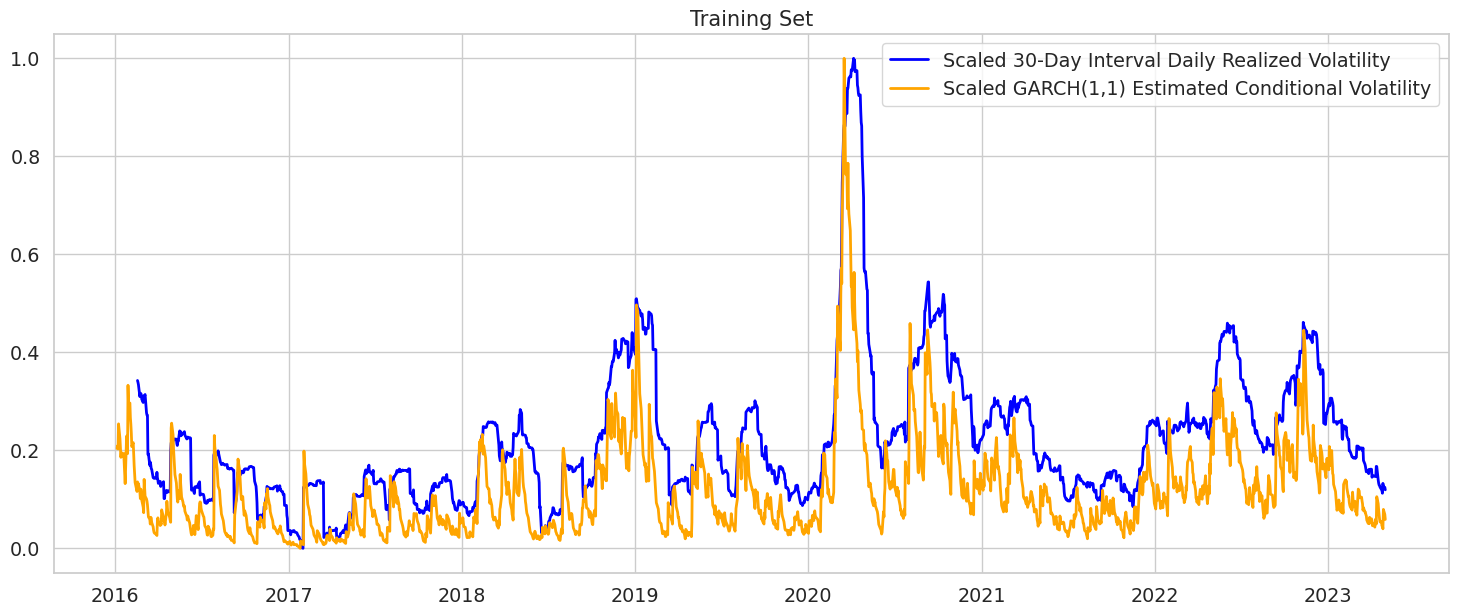

In [42]:
viz_cond_vol(scaled_cond_vol, f'GARCH({p_value},{q_value})')

#**Generate a Forecast: One-Step Expanding Window Forecast**

In [43]:
# PLOTTING MODEL PREDICTIONS VS. TARGET VALUES
def viz_model(y_true, y_pred, model_name):
    sns.set_context("paper", font_scale=1.7)
    plt.rcParams["axes.grid"] = False

    with sns.axes_style("whitegrid"):
        plt.figure(figsize=(18,7))
        plt.plot(x_test_scaled, color='gray',  ls=':',
                label=f"Scaled Current Daily Volatility")

        plt.plot(y_true, color='blue', lw=2,
                label=f"Target Volatility")
        plt.plot(y_pred, color='orange', lw=2.5,
                label=f'Forecasted Volatility')

        plt.title(f'{model_name} \non Test Data')
        plt.legend(loc='best', frameon=True)

In [44]:
# ONE STEP EXPANDING WINDOW FORECAST
# INITIALIZING rolling_forecast
rolling_forecasts = []
idx = df.index

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(n_test)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = n_test[i]
    train = df.returns[:idx]

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, vol='GARCH', p=1, q=1,
                       dist='normal')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    vaR = model_fit.forecast(horizon=n_future,
                             reindex=False).variance.values
    # GET THE SQRT OF AVERAGE n_future DAYS VARIANCE
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

gm_1_preds = pd.Series(rolling_forecasts, index=n_test)

In [45]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
gm_1_preds_scaled = transform_to_scaler(scaler_garch, gm_1_preds)

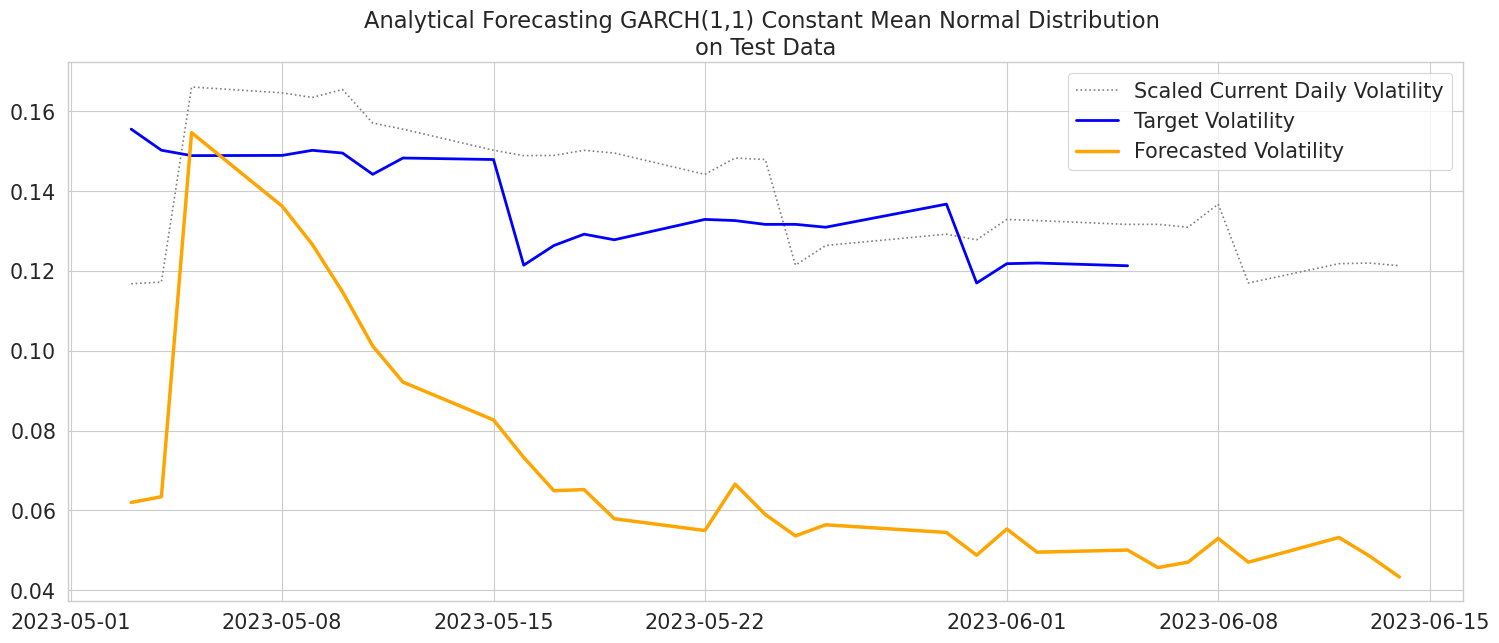

In [46]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_test_scaled, gm_1_preds_scaled,
          f'Analytical Forecasting GARCH({p_value},{q_value}) Constant Mean Normal Distribution')

#**Performance metrics**

Interpret the RMSE (Root Mean Squared Error):
* RMSE represents the square root of the average squared difference between the forecasted volatility and the actual volatility.
* A lower RMSE indicates better accuracy and closer alignment between the forecasted and actual volatility values.
* Compare the RMSE value to the scale of your data to assess its significance.

In [47]:
rmse = np.sqrt(np.mean((gm_1_preds_scaled - df['volatility_current'])**2))

Interpret the MAE (Mean Absolute Error):
* MAE represents the average absolute difference between the forecasted volatility and the actual volatility.
* MAE provides a measure of the average magnitude of the forecast error, regardless of its direction.
* Compare the MAE value to the scale of your data to assess its significance.

In [48]:
mae = np.mean(np.abs(gm_1_preds_scaled - df['volatility_current']))

In [49]:
print("RMSE:", rmse)
print("MAE:", mae)

RMSE: 0.02508468440601157
MAE: 0.019037632962081864
